In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'horses-or-humans-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174300%2F393587%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240707%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240707T133911Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D583c1a819bf8dfade8c2b53f3698db2d62d04651fc1e2133aa3a35e7ca74270d0192b530f51c0c4306ffb81893b96d7fba7de5f66c8296c16ebbce7905247aa66b5b6f5e5dcf220ecc083362afb8b57bf6b22b89745c795be31629cd1033c0bb9abc99699f9aa582f09dffb19113595615706443bc0772b37efb077cce22cfb27b08e6dad7dfca54f2d94cf05ef07f5f72ea9c33e9476d29921c07006dcf0a7b54e422e38c05f6803ddc08da08324a94c915f331d53f5eb0c1b8fb96cca5f09c8479302c3e93d70dbaf92432eb2ffebcda3d2702fcb7221d73e820a34c9198d6e0f8414b0524b17620a77c4efaacdc2c2d2b88247df870051379e14b11c55e5c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 322366720 bytes downloaded
Downloaded and uncompressed: horses-or-humans-dataset
Data source import complete.


In [2]:
import warnings

warnings.filterwarnings('ignore')
train_path = '/kaggle/input/horses-or-humans-dataset/horse-or-human/train'

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(rescale = 1/255)

In [5]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size = (300,300),
        batch_size = 128,
        class_mode = "binary")

Found 1027 images belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers

cnn_model = tf.keras.models.Sequential([
    layers.Input(shape=(300, 300, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [7]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 64)        0

In [8]:
cnn_model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
    metrics = ["accuracy"])

In [9]:
history = cnn_model.fit(
    train_generator,
    epochs = 10)

Epoch 1/10
9/9 [==============================] - 22s 1s/step - loss: 0.7426 - accuracy: 0.5083
Epoch 2/10
9/9 [==============================] - 9s 925ms/step - loss: 0.6117 - accuracy: 0.7459
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.7184 - accuracy: 0.5414
Epoch 4/10
9/9 [==============================] - 10s 1s/step - loss: 0.6028 - accuracy: 0.7079
Epoch 5/10
9/9 [==============================] - 9s 919ms/step - loss: 0.5111 - accuracy: 0.8072
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.2552 - accuracy: 0.8987
Epoch 7/10
9/9 [==============================] - 9s 912ms/step - loss: 0.1783 - accuracy: 0.9211
Epoch 8/10
9/9 [==============================] - 7s 805ms/step - loss: 0.2230 - accuracy: 0.9085
Epoch 9/10
9/9 [==============================] - 8s 981ms/step - loss: 0.1590 - accuracy: 0.9503
Epoch 10/10
9/9 [==============================] - 8s 907ms/step - loss: 0.1569 - accuracy: 0.9435


In [10]:
val_path = '/kaggle/input/horses-or-humans-dataset/horse-or-human/validation'

In [11]:
val_datagen = ImageDataGenerator(rescale = 1/255)

In [12]:
val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (300,300),
        batch_size = 128,
        class_mode = "binary")

Found 256 images belonging to 2 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras import layers

cnn_model = tf.keras.models.Sequential([
    layers.Input(shape=(300, 300, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [14]:
cnn_model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
    metrics = ["accuracy"])

In [15]:
history = cnn_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator)

Epoch 1/10
9/9 [==============================] - 11s 1s/step - loss: 0.9267 - accuracy: 0.4985 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 0.6629 - accuracy: 0.6748 - val_loss: 1.5784 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.6439 - accuracy: 0.6456 - val_loss: 0.5027 - val_accuracy: 0.8086
Epoch 4/10
9/9 [==============================] - 9s 1s/step - loss: 0.6646 - accuracy: 0.7702 - val_loss: 1.5845 - val_accuracy: 0.5195
Epoch 5/10
9/9 [==============================] - 9s 953ms/step - loss: 0.3478 - accuracy: 0.8608 - val_loss: 0.9664 - val_accuracy: 0.7969
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.4366 - accuracy: 0.8403 - val_loss: 1.3815 - val_accuracy: 0.7109
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.1969 - accuracy: 0.9299 - val_loss: 0.4205 - val_accuracy: 0.8867
Epoch 8/10
9/9 [=====================

# İmage augmentation ile modelin ezberlemesinin önüne geçmemiz lazım.

In [32]:
rain_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [33]:
cnn_model = tf.keras.models.Sequential([
    layers.Input(shape=(300, 300, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [34]:
cnn_model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
    metrics = ["accuracy"])

In [35]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size = (300,300),
        batch_size = 128,
        class_mode = "binary")

Found 1027 images belonging to 2 classes.


In [20]:
history = cnn_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator)

Epoch 1/10
9/9 [==============================] - 11s 1s/step - loss: 0.7008 - accuracy: 0.6232 - val_loss: 1.1100 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 0.7946 - accuracy: 0.6271 - val_loss: 0.6423 - val_accuracy: 0.8281
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.6592 - accuracy: 0.7361 - val_loss: 0.6904 - val_accuracy: 0.5156
Epoch 4/10
9/9 [==============================] - 9s 944ms/step - loss: 0.5055 - accuracy: 0.7283 - val_loss: 0.2601 - val_accuracy: 0.8906
Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.5227 - accuracy: 0.7955 - val_loss: 0.4122 - val_accuracy: 0.8828
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.2848 - accuracy: 0.8793 - val_loss: 0.5250 - val_accuracy: 0.8828
Epoch 7/10
9/9 [==============================] - 10s 1s/step - loss: 0.1899 - accuracy: 0.9143 - val_loss: 1.4087 - val_accuracy: 0.7656
Epoch 8/10
9/9 [===================

# Model Tahmini

In [21]:
path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman02-03.png"

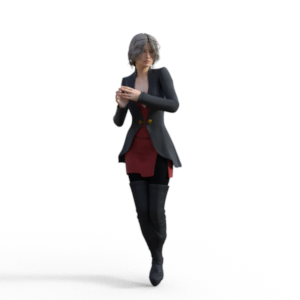

In [22]:
from tensorflow.keras.preprocessing import image
img = image.load_img(path, target_size=(300,300))
img

### Resmi array'e çevirelim

In [23]:
x = image.img_to_array(img)
x.shape

(300, 300, 3)

In [24]:
import numpy as np
x = np.expand_dims(x, axis = 0)
x.shape

(1, 300, 300, 3)

In [25]:
classes = cnn_model.predict(x)

1/1 [==============================] - 1s 553ms/step


In [26]:
if classes[0]>0.5:
    print("Görsel insan")
else:
    print("Görsel at")

Görsel insan


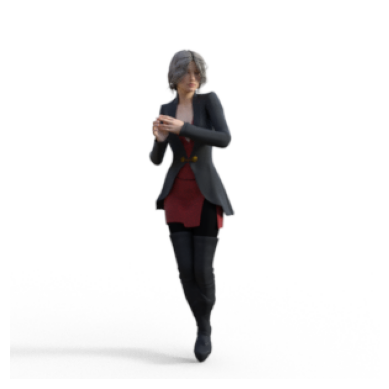

1/1 [==============================] - 0s 19ms/step
Bu bir İnsan.


In [54]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_path = path


img = image.load_img(img_path, target_size=(300, 300))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.0

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()


prediction = cnn_model.predict(img_tensor)

predicted_class = class_names[int(prediction[0] > 0.5)]
print(f"Bu bir {predicted_class}.")